Best threshold found by GA: 148


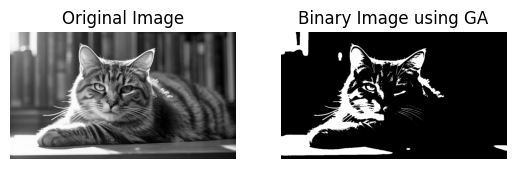

In [ ]:
import numpy as np
import cv2
import random
from sklearn.preprocessing import minmax_scale

# Define the fitness function
def _compute_otsu_criteria(img: np.ndarray, threshold: int) -> float:
    # Compute the Otsu criteria for a given threshold
    foreground = img > threshold
    background = img <= threshold

    weight_foreground = np.sum(foreground) / img.size
    weight_background = np.sum(background) / img.size

    mean_foreground = np.mean(img[foreground]) if weight_foreground > 0 else 0
    mean_background = np.mean(img[background]) if weight_background > 0 else 0

    return weight_foreground * weight_background * (mean_foreground - mean_background) ** 2

# Genetic Algorithm for finding the best threshold
def genetic_algorithm_otsu(img: np.ndarray, pop_size=50, generations=100, mutation_rate=0.01):
    # Initialize population with valid threshold values
    population = np.random.randint(0, 256, pop_size)

    for gen in range(generations):
        # Evaluate fitness for each individual in the population
        fitness = np.array([_compute_otsu_criteria(img, individual) for individual in population])

        # Handle the case where all fitness values are zero
        if np.sum(fitness) == 0:
            fitness += 1e-10

        # Selection (Roulette wheel selection)
        scaled_fitness = minmax_scale(fitness)

        # Ensure scaled_fitness does not result in NaN or Inf
        if np.sum(scaled_fitness) == 0:
            scaled_fitness += 1e-10

        selection_probs = scaled_fitness / np.sum(scaled_fitness)

        # Ensure probabilities are valid
        selection_probs = np.nan_to_num(selection_probs, nan=0.0, posinf=0.0, neginf=0.0)
        if np.sum(selection_probs) == 0:
            selection_probs = np.ones_like(selection_probs) / len(selection_probs)

        selected_indices = np.random.choice(population, size=pop_size, p=selection_probs)

        # Crossover (Single point crossover)
        new_population = []
        for i in range(0, pop_size, 2):
            parent1, parent2 = selected_indices[i], selected_indices[i + 1]
            crossover_point = np.random.randint(1, 8)
            mask = (1 << crossover_point) - 1
            child1 = (parent1 & mask) | (parent2 & ~mask)
            child2 = (parent2 & mask) | (parent1 & ~mask)
            new_population.extend([child1, child2])

        # Mutation
        for i in range(pop_size):
            if random.random() < mutation_rate:
                mutation_point = np.random.randint(8)
                new_population[i] ^= 1 << mutation_point

        population = np.array(new_population)

    # Get the best threshold
    best_threshold = population[np.argmin([_compute_otsu_criteria(img, individual) for individual in population])]
    return best_threshold

# Otsu Thresholding with Genetic Algorithm
def otsu_thresholding_ga(img: np.ndarray) -> np.ndarray:
    best_threshold = genetic_algorithm_otsu(img)
    print(f"Best threshold found by GA: {best_threshold}")

    binary = np.where(img > best_threshold, 255, 0).astype(np.uint8)
    return binary

# Load image
image = cv2.imread('/content/202309281130-main.cropped_1695875469.jpg', 0)

# Apply Otsu's thresholding using Genetic Algorithm
binary_image = otsu_thresholding_ga(image)

# Display the result
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image using GA')
plt.axis('off')

plt.show()


Best threshold found by GA: 139


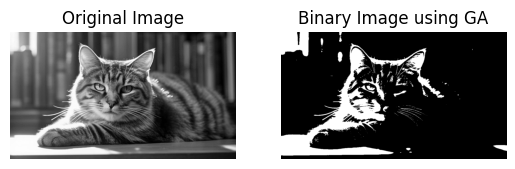

In [16]:
import numpy as np
import cv2
import random
from sklearn.preprocessing import minmax_scale

# Define the fitness function
def _compute_otsu_criteria(img: np.ndarray, threshold: int) -> float:
    # Compute the Otsu criteria for a given threshold
    foreground = img > threshold
    background = img <= threshold

    weight_foreground = np.sum(foreground) / img.size
    weight_background = np.sum(background) / img.size

    mean_foreground = np.mean(img[foreground]) if weight_foreground > 0 else 0
    mean_background = np.mean(img[background]) if weight_background > 0 else 0

    return weight_foreground * weight_background * (mean_foreground - mean_background) ** 2

# Genetic Algorithm for finding the best threshold
def genetic_algorithm_otsu(img: np.ndarray, pop_size=100, generations=200, mutation_rate=0.01, elite_size=5):
    random.seed(42)  # Set random seed for reproducibility
    np.random.seed(42)  # Set numpy random seed for reproducibility

    # Initialize population with valid threshold values
    population = np.random.randint(0, 256, pop_size)

    for gen in range(generations):
        # Evaluate fitness for each individual in the population
        fitness = np.array([_compute_otsu_criteria(img, individual) for individual in population])

        # Handle the case where all fitness values are zero
        if np.sum(fitness) == 0:
            fitness += 1e-10

        # Selection (Roulette wheel selection)
        scaled_fitness = minmax_scale(fitness)

        # Ensure scaled_fitness does not result in NaN or Inf
        if np.sum(scaled_fitness) == 0:
            scaled_fitness += 1e-10

        selection_probs = scaled_fitness / np.sum(scaled_fitness)

        # Ensure probabilities are valid
        selection_probs = np.nan_to_num(selection_probs, nan=0.0, posinf=0.0, neginf=0.0)
        if np.sum(selection_probs) == 0:
            selection_probs = np.ones_like(selection_probs) / len(selection_probs)

        selected_indices = np.random.choice(population, size=pop_size - elite_size, p=selection_probs)

        # Elitism: Preserve the top elite_size individuals
        elite_indices = population[np.argsort(fitness)[-elite_size:]]

        # Crossover (Single point crossover)
        new_population = []
        for i in range(0, len(selected_indices), 2):
            parent1 = selected_indices[i]
            if i + 1 < len(selected_indices):
                parent2 = selected_indices[i + 1]
            else:
                parent2 = selected_indices[0]  # In case of odd number, pair last one with the first

            crossover_point = np.random.randint(1, 8)
            mask = (1 << crossover_point) - 1
            child1 = (parent1 & mask) | (parent2 & ~mask)
            child2 = (parent2 & mask) | (parent1 & ~mask)
            new_population.extend([child1, child2])

        # Mutation
        for i in range(len(new_population)):
            if random.random() < mutation_rate:
                mutation_point = np.random.randint(8)
                new_population[i] ^= 1 << mutation_point

        # Ensure new_population size matches the original population size
        new_population = new_population[:pop_size - elite_size]

        # Combine new population with elites
        population = np.concatenate((new_population, elite_indices))

    # Get the best threshold
    best_threshold = population[np.argmax([_compute_otsu_criteria(img, individual) for individual in population])]
    return best_threshold

# Otsu Thresholding with Genetic Algorithm
def otsu_thresholding_ga(img: np.ndarray) -> np.ndarray:
    best_threshold = genetic_algorithm_otsu(img)
    print(f"Best threshold found by GA: {best_threshold}")

    binary = np.where(img > best_threshold, 255, 0).astype(np.uint8)
    return binary

# Load image
image = cv2.imread('/content/202309281130-main.cropped_1695875469.jpg', 0)

# Apply Otsu's thresholding using Genetic Algorithm
binary_image = otsu_thresholding_ga(image)

# Display the result
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image using GA')
plt.axis('off')

plt.show()